<a href="https://colab.research.google.com/github/junxnone/examples/blob/master/pytorch/pytorch_dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!rm -fr *

In [3]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip

--2020-12-11 09:33:38--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.24.36.112, 2600:1402:6800:283::e59, 2600:1402:6800:297::e59
Connecting to download.microsoft.com (download.microsoft.com)|184.24.36.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   173MB/s    in 4.6s    

2020-12-11 09:33:42 (170 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



In [4]:
def plot_ds(data_loader, N=8):
  i = 1
  plt.figure(figsize=(20, 5 * N//4 + 1))
  for data in data_loader:
      inputs, labels = data
      plt.subplot(N//4 + 1,4,i)
      plt.imshow(torch.transpose(inputs.squeeze(), 0, 2))
      i += 1
      if i > N:
          break

# torchvision.datasets.ImageFolder

In [5]:
!ls PetImages/

Cat  Dog


In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
idataset = datasets.ImageFolder('./PetImages/', data_transforms['train'])

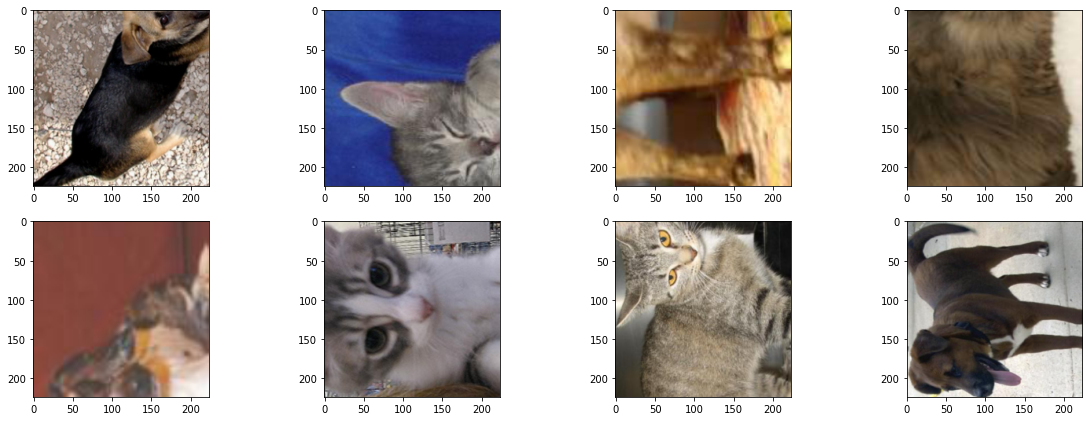

In [8]:
idataloader = torch.utils.data.DataLoader(idataset, batch_size=1, shuffle=True, num_workers=1)
plot_ds(idataloader)

# torch.utils.data.Dataset

In [9]:
!rm -fr all
!mkdir -p all
!cp PetImages/Dog/ all -fr
!cp PetImages/Cat/ all -fr
%cd all
!rename 's/\//_/g' */*.jpg
!rm -fr Dog Cat
%cd -
!echo "filename,class"> labels.csv
!ls all/*.jpg|awk -F "[/_]" '{print $0","$2}'>> labels.csv
!cat labels.csv|wc -l
!head -n 10 labels.csv

/content/all
/content
25001
filename,class
all/Cat_0.jpg,Cat
all/Cat_10000.jpg,Cat
all/Cat_10001.jpg,Cat
all/Cat_10002.jpg,Cat
all/Cat_10003.jpg,Cat
all/Cat_10004.jpg,Cat
all/Cat_10005.jpg,Cat
all/Cat_10006.jpg,Cat
all/Cat_10007.jpg,Cat


In [10]:
class dog_cat_dataset(torch.utils.data.Dataset):
  def __init__(self, csv_labels, preload=True):
    self.preload = preload
    self.df = pd.read_csv(csv_labels)
    self.images_name = list(self.df['filename'])
    self.labels = list(self.df['class'])
    self.num_classes = len(set(self.labels))
    self.classes_name = sorted(set(self.labels))
    self.class_to_idx = {self.classes_name[i]: i for i in range(len(self.classes_name))}
    
    self.images = list()
    if preload:
      self.load_images()
    self.labels_value = [self.class_to_idx[i] for i in self.labels]
    
  def load_images(self):
    for ipath in self.images_name:
      if not os.path.exists(ipath):
        print('invalid image {ipath}')
      img = cv2.imread(ipath)
      if img is None:
        print(ipath)
      
      img = np.transpose(img, [2, 0, 1])
      self.images.append(img)

  def __len__(self):
    return len(self.images_name)

  def __getitem__(self, index):
    if self.preload:
      return self.images[index], self.labels_value[index]
    else:
      img = cv2.imread(self.images_name[index])
      img = np.transpose(img, [2, 0, 1])
      label = self.labels_value[index]
      return img, label

In [ ]:
dcds_pre = dog_cat_dataset('labels.csv')
idataloader_pre = torch.utils.data.DataLoader(dcds_pre, batch_size=1, shuffle=True, num_workers=1)
plot_ds(idataloader_pre)

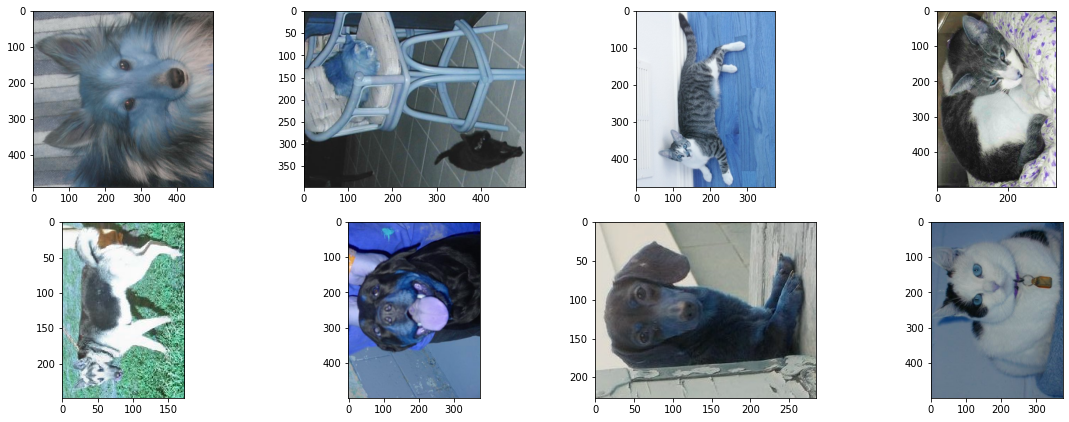

In [30]:
dcds = dog_cat_dataset('labels.csv', preload=False)
idataloader = torch.utils.data.DataLoader(dcds, batch_size=1, shuffle=True, num_workers=1)
plot_ds(idataloader)

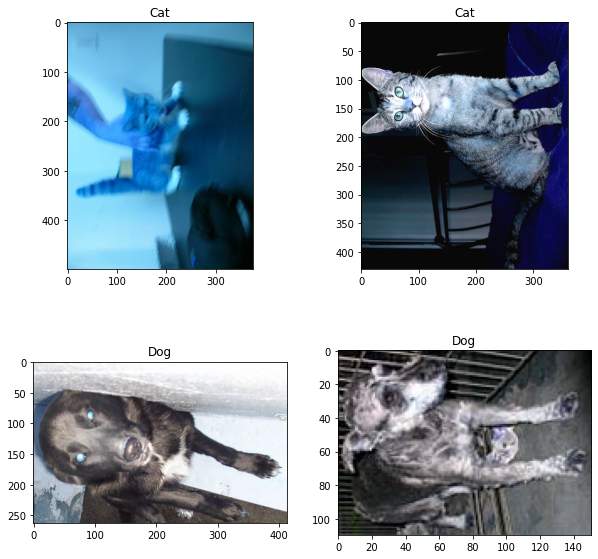

In [31]:
idxs = [0, 1, 12501, 12502]
plt.figure(figsize=(10,10))
for idx in idxs:
  img, label = dcds[idx]
  plt.subplot(2,2,idxs.index(idx)+1)
  plt.imshow(np.transpose(img, [2, 1, 0]))
  plt.title(f'{dcds.classes_name[label]}')